# Exploratory Data Analysis (EDA)

## Import libraries

In [34]:
%matplotlib inline

import warnings
# Load/Review/Visualize
from zipfile import ZipFile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for K-Mean
from sklearn.cluster import KMeans
from pandas.plotting import parallel_coordinates
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# Model/Prediction
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm 

import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np   # linear algebra
import matplotlib.pyplot as plt  #graphs and plots
import seaborn as sns   #data visualizations 
import csv # Some extra functionalities for csv  files - reading it as a dictionary
from lightgbm import LGBMClassifier #sklearn is for machine learning and statistical modeling including classification, regression, clustering and dimensionality reduction 

from sklearn.model_selection import train_test_split, cross_validate   #break up dataset into train and test sets

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# importing python library for working with missing data
import missingno as msno
# To install missingno use: !pip install missingno
import re    # This library is used to perform regex pattern matching

# import various functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,\
                            precision_score, recall_score, roc_auc_score,\
                            classification_report, f1_score

import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings("ignore")



## Import the dataset

In [35]:
df = pd.read_csv('/Users/marialozano/Documents/GitHub/CleanDiabetes_Dataset/prediction/GROUP PROJECT/diabetic_data_CLEANED.csv')

In [36]:
high_importance_value = ['number_inpatient', 'age', 'number_emergency', 'diag_1', 'diag_2', 'diag_3', 'gender', 'discharge_disposition_id', 'number_diagnoses', 'metformin', 'number_outpatient', 'max_glu_serum', 'num_medications', 'time_in_hospital', 'admission_source_id','readmitted']

## Break the data into Train & Test

In [37]:
train_df, valid_df, test_df = np.split(df[high_importance_value].sample(frac=1, random_state=42), 
                                       [int(.7*len(df[high_importance_value])), int(0.85*len(df[high_importance_value]))])
train_df = train_df.reset_index(drop = True)
valid_df = valid_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

In [38]:
df[high_importance_value].readmitted.value_counts()

0    54598
1     5069
Name: readmitted, dtype: int64

In [39]:
train_df.readmitted.value_counts()

0    38211
1     3555
Name: readmitted, dtype: int64

In [40]:
valid_df.readmitted.value_counts()

0    8235
1     715
Name: readmitted, dtype: int64

In [41]:
test_df.readmitted.value_counts()

0    8152
1     799
Name: readmitted, dtype: int64

In [42]:
## Treating the Imbalance in the Data

In [43]:
def calc_prevalence(y_actual):
    
    '''
    This function is to understand the ratio/distribution of the classes that we are going to predict for.
    
    Params:
    1. y_actual: The target feature
    
    Return:
    1. (sum(y_actual)/len(y_actual)): The ratio of the positive class in the complete data.
    '''
    
    return (sum(y_actual)/len(y_actual))

In [44]:
# split the training data into positive and negative
rows_pos = train_df.readmitted == 1
df_train_pos = train_df.loc[rows_pos]
df_train_neg = train_df.loc[~rows_pos]

# merge the balanced data
readmitted_df_balanced = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 111)],axis = 0)

# shuffle the order of training samples 
readmitted_df_balanced = readmitted_df_balanced.sample(n = len(readmitted_df_balanced), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(readmitted_df_balanced), \
                                                calc_prevalence(readmitted_df_balanced.readmitted.values)))

Train balanced prevalence(n = 7110):0.500


In [45]:
readmitted_df_balanced.readmitted.value_counts()

1    3555
0    3555
Name: readmitted, dtype: int64

In [46]:
X_train = readmitted_df_balanced.drop('readmitted',axis=1)

y_train = readmitted_df_balanced['readmitted']

X_valid = valid_df.drop('readmitted',axis=1)

y_valid = valid_df['readmitted']

X_test = test_df.drop('readmitted',axis=1)

y_test = test_df['readmitted']

## Creating and Understanding Models

In [47]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh = 0.5):
    
    '''
    This function calculates all the metrics to asses the machine learning models.
    
    Params:
    1. y_actual: The actual values for the target variable.
    2. y_pred: The predicted values for the target variable.
    3. thresh: The threshold for the probability to be considered as a positive class. Default value 0.5
    
    Return:
    1. AUC
    2. Accuracy
    3. Recall
    4. Precision
    5. Specificity
    '''
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

### Linear Regression

In [48]:
lnr = LinearRegression()
lnr.fit(X_train, y_train)

y_valid_preds = lnr.predict(X_valid)

In [49]:
y_valid_preds

array([0.44160282, 0.45460753, 0.52442404, ..., 0.45147968, 0.44861148,
       0.5026148 ])

### Logistic Regression

In [50]:
lr=LogisticRegression(random_state = 42, solver = 'newton-cg', max_iter = 200)
lr.fit(X_train, y_train)

y_valid_preds = lr.predict_proba(X_valid)[:,1]

print('Metrics for Validation data:')

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, 0.5)

Metrics for Validation data:
AUC:0.592
accuracy:0.591
recall:0.523
precision:0.101
specificity:0.597
prevalence:0.080
 


### KNN Model

In [51]:
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train, y_train)

knn_preds = knn.predict_proba(X_valid)[:,1]

knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,knn_preds, 0.5)

AUC:0.549
accuracy:0.601
recall:0.467
precision:0.095
specificity:0.547
prevalence:0.080
 


## Stochastic Gradient Descent Model

In [52]:
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train, y_train)

sgd_preds = sgdc.predict_proba(X_valid)[:,1]

print('Stochastic Gradient Descent')
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, \
                sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,sgd_preds, 0.5)

Stochastic Gradient Descent
Validation:
AUC:0.592
accuracy:0.642
recall:0.470
precision:0.106
specificity:0.657
prevalence:0.080
 


### Decision Tree

In [53]:
dc_clf = DecisionTreeClassifier(random_state=42, max_depth = 10)
dc_clf.fit(X_train, y_train)

dc_preds_proba = dc_clf.predict_proba(X_valid)[:,1]
dc_preds = dc_clf.predict(X_valid)

dc_valid_auc, dc_valid_accuracy, dc_valid_recall, \
    dc_valid_precision, dc_valid_specificity = print_report(y_valid,dc_preds_proba, 0.5)

AUC:0.594
accuracy:0.640
recall:0.515
precision:0.114
specificity:0.636
prevalence:0.080
 


### Random Forest

In [54]:
rf_clf = RandomForestClassifier(random_state=111, max_depth = 6)

rf_clf.fit(X_train, y_train)

rf_preds = rf_clf.predict(X_valid)
rf_preds_proba = rf_clf.predict_proba(X_valid)[:, 1]

rf_valid_auc, rf_valid_accuracy, rf_valid_recall, \
    rf_valid_precision, rf_valid_specificity = print_report(y_valid,rf_preds_proba, 0.5)

AUC:0.626
accuracy:0.636
recall:0.533
precision:0.115
specificity:0.645
prevalence:0.080
 


### Linear SVC

In [55]:
lsvc_clf = LinearSVC(random_state=111)
lsvc_clf.fit(X_train, y_train)

lsvc_preds = lsvc_clf.decision_function(X_valid)

lsvc_valid_auc, lsvc_valid_accuracy, lsvc_valid_recall, \
    lsvc_valid_precision, lsvc_valid_specificity = print_report(y_valid,lsvc_preds, 0.5)

AUC:0.574
accuracy:0.917
recall:0.001
precision:0.038
specificity:0.997
prevalence:0.080
 


### Gradient Boosting Model

In [56]:
gb_clf = GradientBoostingClassifier(n_estimators = 100, criterion='friedman_mse', learning_rate = 1.0, max_depth = 3,\
                                    random_state = 111)

gb_clf.fit(X_train, y_train)
gb_preds = gb_clf.predict(X_valid)
gb_preds_proba = gb_clf.predict_proba(X_valid)[:, 1]

gb_valid_auc, gb_valid_accuracy, gb_valid_recall, \
    gb_valid_precision, gb_valid_specificity = print_report(y_valid,gb_preds_proba, 0.5)

AUC:0.564
accuracy:0.571
recall:0.519
precision:0.096
specificity:0.576
prevalence:0.080
 


### XGB Model

In [57]:
xgb_clf = xgb.XGBClassifier(max_depth=3, learning_rate = 1.0, use_label_encoder = False,\
                            eval_metric = 'logloss')
xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_valid)
xgb_preds_proba = xgb_clf.predict_proba(X_valid)[:, 1]

xgb_valid_auc, xgb_valid_accuracy, xgb_valid_recall, \
    xgb_valid_precision, xgb_valid_specificity = print_report(y_valid,xgb_preds_proba, 0.5)

AUC:0.573
accuracy:0.576
recall:0.513
precision:0.096
specificity:0.582
prevalence:0.080
 


### Catboost Model

In [58]:
catb=CatBoostClassifier(iterations=200, depth=3, learning_rate=1.0, random_state = 111)
catb.fit(X_train, y_train)
catb_preds = catb.predict_proba(X_valid)[:, 1]

catb_valid_auc, catb_valid_accuracy, catb_valid_recall, \
    catb_valid_precision, catb_valid_specificity = print_report(y_valid,catb_preds, 0.5)

0:	learn: 0.6765744	total: 1.45ms	remaining: 288ms
1:	learn: 0.6734027	total: 3.17ms	remaining: 314ms
2:	learn: 0.6715077	total: 4.53ms	remaining: 297ms
3:	learn: 0.6702084	total: 5.91ms	remaining: 290ms
4:	learn: 0.6689776	total: 7.59ms	remaining: 296ms
5:	learn: 0.6682985	total: 9.14ms	remaining: 296ms
6:	learn: 0.6673770	total: 10.7ms	remaining: 295ms
7:	learn: 0.6668436	total: 12.2ms	remaining: 293ms
8:	learn: 0.6637536	total: 13.6ms	remaining: 288ms
9:	learn: 0.6617309	total: 14.8ms	remaining: 281ms
10:	learn: 0.6602827	total: 16.2ms	remaining: 278ms
11:	learn: 0.6587957	total: 17.6ms	remaining: 275ms
12:	learn: 0.6568410	total: 19ms	remaining: 274ms
13:	learn: 0.6560407	total: 20.6ms	remaining: 274ms
14:	learn: 0.6549801	total: 22.2ms	remaining: 273ms
15:	learn: 0.6539619	total: 23.6ms	remaining: 271ms
16:	learn: 0.6528945	total: 24.9ms	remaining: 268ms
17:	learn: 0.6522107	total: 26.2ms	remaining: 265ms
18:	learn: 0.6513247	total: 27.7ms	remaining: 264ms
19:	learn: 0.6504409	tot

### Hyper Parameter Tuning

In [59]:
recall_scoring = make_scorer(recall_score)

### Decision Tree - Hyper Parameter Tuning

In [60]:
dc_grid = {'max_features':['auto','sqrt'], # maximum number of features to use at each split
           'max_depth':range(1,11,1), # maximum depth of the tree
           'min_samples_split':range(2,10,2), # minimum number of samples to split a node
           'criterion':['gini','entropy']} # criterion for evaluating a split

dc_random = RandomizedSearchCV(estimator = dc_clf, param_distributions = dc_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

dc_random.fit(X_train, y_train)

dc_random.best_params_

dc_hp_preds = dc_random.best_estimator_.predict(X_valid)
dc_hp_preds_proba = dc_random.best_estimator_.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, dc_hp_preds_proba)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


0.6006767973981089

In [61]:
recall_score(y_valid, dc_hp_preds)

0.48671328671328673

### Random Forest - Hyper Parameter Tuning

In [62]:
rf_grid = {'n_estimators':range(200,1000,200), # number of trees
           'max_features':['auto','sqrt'], # maximum number of features to use at each split
           'max_depth':range(1,11,1), # maximum depth of the tree
           'min_samples_split':range(2,10,2), # minimum number of samples to split a node
           'criterion':['gini','entropy']} # criterion for evaluating a split

rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = rf_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

rf_random.fit(X_train, y_train)

rf_random.best_params_

rf_hp_preds = rf_random.best_estimator_.predict(X_valid)
rf_hp_preds_proba = rf_random.best_estimator_.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, rf_hp_preds_proba)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


0.623717715193125

In [63]:
recall_score(y_valid, rf_hp_preds)

0.5314685314685315

### XGBoost - Hyper Parameter Tuning

In [64]:
xgb_grid = params = {
        'min_child_weight': [1, 5, 8, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
        'max_depth': [3, 4, 5]
        } # criterion for evaluating a split

xgb_random = GridSearchCV(estimator = xgb_clf, param_grid = xgb_grid, 
                               cv = 2, scoring = recall_scoring,
                               verbose = 1)

xgb_random.fit(X_train, y_train)

xgb_random.best_params_

xgb_hp_preds = xgb_random.best_estimator_.predict(X_valid)
xgb_hp_preds_proba = xgb_random.best_estimator_.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, xgb_hp_preds_proba)

Fitting 2 folds for each of 720 candidates, totalling 1440 fits


0.5918462472560833

In [65]:
recall_score(y_valid, xgb_hp_preds)

0.5160839160839161

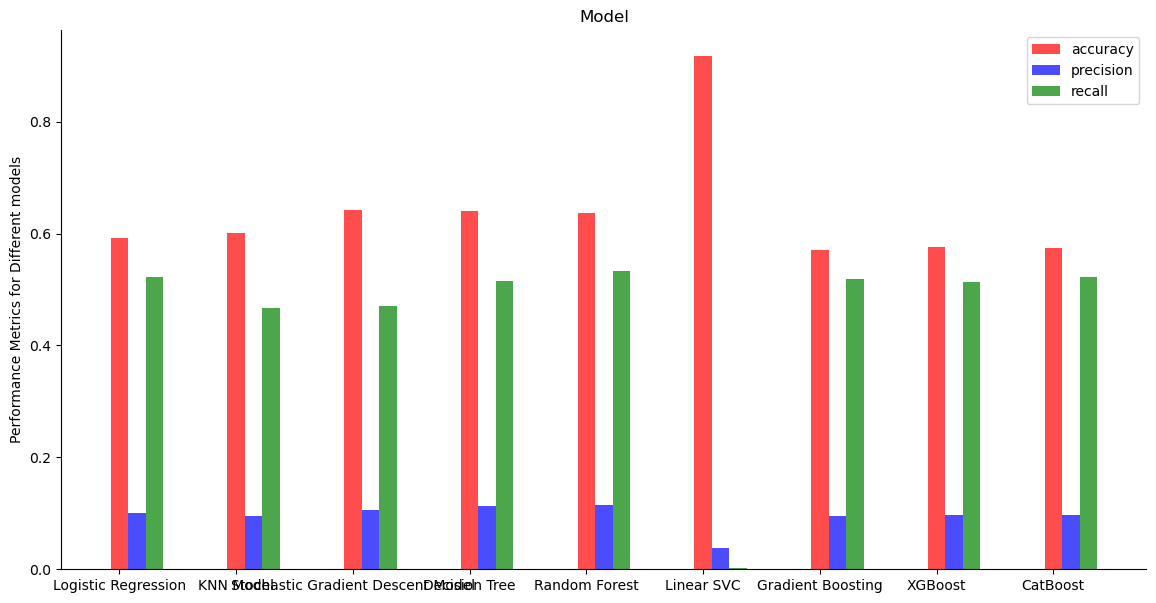

In [69]:
plt.figure(figsize=(14, 7))
ax = plt.subplot(111)

models = ['Logistic Regression', 'KNN Model', 'Stochastic Gradient Descent Model', 'Decision Tree', 'Random Forest', 'Linear SVC', 'Gradient Boosting', 'XGBoost', 'CatBoost']
values = [lr_valid_accuracy, knn_valid_accuracy, sgdc_valid_accuracy, dc_valid_accuracy, rf_valid_accuracy, lsvc_valid_accuracy, gb_valid_accuracy, xgb_valid_accuracy, catb_valid_accuracy]
model = np.arange(len(models))

plt.bar(model, values, align='center', width = 0.15, alpha=0.7, color = 'red', label = 'accuracy')
plt.xticks(model, models)
           

           
ax = plt.subplot(111)

models = ['Logistic Regression', 'KNN Model', 'Stochastic Gradient Descent Model', 'Decision Tree', 'Random Forest', 'Linear SVC', 'Gradient Boosting', 'XGBoost', 'CatBoost']
values = [lr_valid_precision, knn_valid_precision, sgdc_valid_precision, dc_valid_precision, rf_valid_precision, lsvc_valid_precision, gb_valid_precision, xgb_valid_precision, catb_valid_precision]
model = np.arange(len(models))

plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'precision')
plt.xticks(model, models)



ax = plt.subplot(111)

models = ['Logistic Regression', 'KNN Model', 'Stochastic Gradient Descent Model', 'Decision Tree', 'Random Forest', 'Linear SVC', 'Gradient Boosting', 'XGBoost', 'CatBoost']
values = [lr_valid_recall, knn_valid_recall, sgdc_valid_recall, dc_valid_recall, rf_valid_recall, lsvc_valid_recall, gb_valid_recall, xgb_valid_recall, catb_valid_recall]
model = np.arange(len(models))

plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'green', label = 'recall')
plt.xticks(model, models)



plt.ylabel('Performance Metrics for Different models')
plt.title('Model')
    
# removing the axis on the top and right of the plot window
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.show()    

### ANOVA Regression

In [20]:
###########################
####  IMPORT PACKAGES  ####
###########################

from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import patsy  # to create design matrices
import matplotlib.pyplot
import researchpy as rp 
from plotly import express
from plotly import io  # to set the graph to dark mode (just aesthetics)
from plotly import graph_objects
import matplotlib.pyplot as plt
from bioinfokit.analys import stat
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
io.templates.default = 'plotly_dark'

##########################
####  IMPORT DATASET  ####
##########################

# load data file
df = pd.read_csv('/Users/marialozano/Documents/GitHub/CleanDiabetes_Dataset/prediction/GROUP PROJECT/diabetic_data_CLEANED.csv')


In [29]:
##  4. Work on ANOVAs
# NULL hypothesis: there is no difference in the means
#    - Group by Readmission type 


# - continuous values (independent Variables)
# 'number_inpatient', 'age', 
# 'number_emergency', 'diag_1', 'diag_2', 
# 'diag_3', 'gender', 'discharge_disposition_id', 
# 'number_diagnoses', 'metformin', 'number_outpatient', 
# 'max_glu_serum', 'num_medications', 'time_in_hospital',
# 'admission_source_id','readmitted']
# 

# - categorical values (dependent Variable)
# - Readmission

# 5. Explore Grouped Values
# - group by high anxiety, low anxiety
# - need to define high and low
# - compare the grouped values with the other values
# - i.e. anxiety vs days out of the house

# 6. T-Tests for Possible Correlations
# - see if there is relationships between the values
# - days out of the house vs season
# - phq9 vs season

# 7. Visualizations of the above analysis 

# #Dependent Variables 
## Readmission

#Independent Variables 

# Get descriptive statistics of phq9


count    59667.000000
mean         0.084955
std          0.278817
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: readmitted, dtype: float64

In [8]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'service_utilization', 'numchange', 'nummed', 'number_inpatient_log1p',
       'service_utilization_log1p', 'number_outpatient_log1p',
       'number_emergency_log1p', 'num_medications|time_in_hospital

In [13]:
# # ['race', 'gender', 'age', 'admission_type_id',
#        'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
#        'num_lab_procedures', 'num_procedures', 'num_medications',
#        'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
#        'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
#        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
#        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
#        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
#        'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
#        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#        'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
#        'service_utilization', 'numchange', 'nummed', 'number_inpatient_log1p',
#        'service_utilization_log1p', 'number_outpatient_log1p',
#        'number_emergency_log1p', 'num_medications|time_in_hospital',
#        'num_medications|num_procedures', 'time_in_hospital|num_lab_procedures',
#        'num_medications|num_lab_procedures',
#        'num_medications|number_diagnoses', 'age|number_diagnoses',
#        'change|num_medications', 'number_diagnoses|time_in_hospital',
#        'num_medications|numchange']


In [30]:
readmission = df['readmitted'].describe()
readmission

high_importance_value = ['number_inpatient', 'age', 'number_emergency', 'diag_1', 'diag_2', 'diag_3', 'gender', 'discharge_disposition_id', 'number_diagnoses', 'metformin', 'number_outpatient', 'max_glu_serum', 'num_medications', 'time_in_hospital', 'admission_source_id','readmitted']
df[high_importance_value].readmitted.value_counts()




0    54598
1     5069
Name: readmitted, dtype: int64